In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import random
import gc
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

In [2]:
%%time
base_path = "/kaggle/input/m5-forecasting-accuracy/"
calendar = pd.read_csv(f"{base_path}calendar.csv")
train_eva = pd.read_csv(f"{base_path}sales_train_evaluation.csv")
sell_prices = pd.read_csv(f"{base_path}sell_prices.csv")
sample_sub = pd.read_csv(f"{base_path}sample_submission.csv")

CPU times: user 6.98 s, sys: 1.24 s, total: 8.21 s
Wall time: 11 s


In [3]:
# Add more columns in file train
for d in range(1942,1970):
    col = 'd_' + str(d)
    train_eva[col] = 0
    train_eva[col] = train_eva[col].astype(np.int16)

In [4]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [5]:
%%time
print("Downcasting data")
train_eva = downcast(train_eva)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

Downcasting data
CPU times: user 1min 33s, sys: 1min 25s, total: 2min 59s
Wall time: 2min 59s


In [6]:
%%time
print("Melting data")
df = pd.melt(frame=train_eva, 
             id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
             var_name="d", value_name="sold")

Melting data
CPU times: user 6.37 s, sys: 3.22 s, total: 9.59 s
Wall time: 9.58 s


In [7]:
%%time
print("Merging data")
df = pd.merge(left=df, right=calendar, how="left", on="d")
df = pd.merge(left=df, right=sell_prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")

Merging data
CPU times: user 30.5 s, sys: 9.14 s, total: 39.6 s
Wall time: 39.6 s


In [8]:
%%time
print("Implement features")
#Calculate the SNAP (Supplemental Nutrition Assistance Program) day for each state
df["snap"] = df["snap_CA"] + df["snap_TX"] + df["snap_WI"]
df["snap"] = np.where(df["snap"] >= 1, 1, 0).astype(np.int8)

# Apply int for day column
df["d"] = df["d"].str[2:].astype(np.int16)

# Process NaN value
df["sell_price"] = df['sell_price'].fillna(df.groupby('id')['sell_price'].transform('median'))

# Is it a weekend
df["weekend"] = np.where(df["wday"] < 3, 1, 0).astype(np.int8)

# Drop unnecessary columns
df = df.drop(["date", "weekday", "wm_yr_wk", "event_name_2", "event_type_2", "snap_CA", "snap_TX", "snap_WI"], axis=1)

Implement features
CPU times: user 26.6 s, sys: 3.7 s, total: 30.3 s
Wall time: 30.3 s


In [9]:
# Create total sale for each store
sum_df = df.groupby(["store_id", "d"])["sold"].sum().reset_index()
df = pd.merge(left=df, right=sum_df, how="left", on=["d", "store_id"])
df.rename(columns={'sold_x': 'sold','sold_y': 'total_sale'}, inplace=True)

In [10]:
# Label Encoder
print("Label Encoding")
d_id = dict(zip(df["id"].cat.codes, df["id"]))
d_store = dict(zip(df["store_id"].cat.codes, df["store_id"]))
df["id"] = df["id"].cat.codes
df["item_id"] = df["item_id"].cat.codes
df["dept_id"] = df["dept_id"].cat.codes
df["cat_id"] = df["cat_id"].cat.codes
df["store_id"] = df["store_id"].cat.codes
df["state_id"] = df["state_id"].cat.codes
df["event_name_1"] = df["event_name_1"].cat.codes
df["event_type_1"] = df["event_type_1"].cat.codes

Label Encoding


In [11]:
%%time
print("Mean Encoding")
df["state_mean"] = df.groupby("state_id")["sold"].transform("mean").astype(np.float16)
df["store_mean"] = df.groupby("store_id")["sold"].transform("mean").astype(np.float16)
df["cat_mean"] = df.groupby("cat_id")["sold"].transform("mean").astype(np.float16)
df["dept_mean"] = df.groupby("dept_id")["sold"].transform("mean").astype(np.float16)
df["state_cat_mean"] = df.groupby(["state_id", "cat_id"])["sold"].transform("mean").astype(np.float16)
df["state_dept_mean"] = df.groupby(["state_id", "dept_id"])["sold"].transform("mean").astype(np.float16)
df["store_cat_mean"] = df.groupby(["store_id", "cat_id"])["sold"].transform("mean").astype(np.float16)
df["store_cat_mean"] = df.groupby(["dept_id", "cat_id"])["sold"].transform("mean").astype(np.float16)
df["item_id_mean"] = df.groupby("item_id")["sold"].transform("mean").astype(np.float16)
df["item_state_mean"] = df.groupby(["item_id", "state_id"])["sold"].transform("mean").astype(np.float16)
df["item_store_mean"] = df.groupby(["item_id", "store_id"])["sold"].transform("mean").astype(np.float16)

print("Median Encoding")
df["state_median"] = df.groupby("state_id")["sold"].transform("median").astype(np.float16)
df["store_median"] = df.groupby("store_id")["sold"].transform("median").astype(np.float16)
df["cat_median"] = df.groupby("cat_id")["sold"].transform("median").astype(np.float16)
df["dept_median"] = df.groupby("dept_id")["sold"].transform("median").astype(np.float16)
df["state_cat_median"] = df.groupby(["state_id", "cat_id"])["sold"].transform("median").astype(np.float16)
df["state_dept_median"] = df.groupby(["state_id", "dept_id"])["sold"].transform("median").astype(np.float16)
df["store_cat_median"] = df.groupby(["store_id", "cat_id"])["sold"].transform("median").astype(np.float16)
df["store_cat_median"] = df.groupby(["dept_id", "cat_id"])["sold"].transform("median").astype(np.float16)
df["item_id_median"] = df.groupby("item_id")["sold"].transform("median").astype(np.float16)
df["item_state_median"] = df.groupby(["item_id", "state_id"])["sold"].transform("median").astype(np.float16)
df["item_store_median"] = df.groupby(["item_id", "store_id"])["sold"].transform("median").astype(np.float16)

Mean Encoding
Median Encoding
CPU times: user 1min 4s, sys: 19.3 s, total: 1min 24s
Wall time: 1min 24s


In [12]:
%%time
print("Calulating Lags")
# Lags must be > 28
lags = [29,30,31,32,33,34,35,40,55,60,65,180]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

Calulating Lags
CPU times: user 1min 55s, sys: 52.9 s, total: 2min 48s
Wall time: 2min 48s


In [13]:
# Drop NaN
df = df[df['d']>max(lags)]

In [14]:
# Save dataframe
df.to_pickle('data.pkl')
del df
gc.collect()

0

The key part of the process is handling empty features in the next 28 days. 

This is why the lagging in the model is not less than 28 days. 

If the lagging is less than 28 days, when performing recursive prediction, we would have to use the predicted value to forecast the future, which would introduce errors and negatively impact the prediction accuracy. 

However, if we predict the total sales instead of individual items, it will result in fewer errors compared to predicting each item separately. 

This idea is inspired by the top two leaderboard entries.

In [15]:
# Create store dataframe for model predict total sale for store
def create_store_df(train_eva, store):
    train = train_eva[train_eva["id"].str.contains(store)]
    
    df = pd.melt(frame=train, 
                 id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name="d", value_name="sold")
    sum_df = df.groupby(["d", "store_id"])["sold"].sum().reset_index()
    df = pd.merge(left=df.drop("sold", axis=1), right=sum_df, how="left", on=["d", "store_id"])[["store_id", "state_id", "d", "sold"]]
    df.drop_duplicates(inplace=True)
    
    df = pd.merge(left=df, right=calendar, how="left", on="d")
    
    df = df.drop(["store_id", "state_id", "date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df["d"] = df["d"].str[2:].astype(np.int16)
    
    df["event_name_1"] = df["event_name_1"].cat.codes
    df["event_type_1"] = df["event_type_1"].cat.codes
    
    return df

In [16]:
%%time
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]

CPU times: user 525 ms, sys: 3.17 s, total: 3.69 s
Wall time: 3.7 s


In [17]:
params = {"objective" : "tweedie",
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'n_estimators': 1000,
        'force_row_wise':True,
        'lambda_l2':1
}

In [18]:
%%time
for i in range(10): 
    #Predict total sale of a store
    store_df = create_store_df(train_eva, d_store[i])
    X_train, y_train = store_df[store_df["d"] < 1914].drop("sold", axis=1), store_df[store_df["d"] < 1914]["sold"]
    train_sets = lgb.Dataset(X_train, y_train)
    X_valid, y_valid = store_df[(store_df["d"] >= 1914) & (store_df["d"] < 1942)].drop("sold", axis=1), store_df[(store_df["d"] >= 1914) & (store_df["d"] < 1942)]["sold"]
    valid_sets = lgb.Dataset(X_valid, y_valid)
    X_test, y_test = store_df[store_df["d"] >= 1942].drop("sold", axis=1), store_df[store_df["d"] >= 1942]["sold"] 
    updated_index = y_test.index.map(lambda x: x + 1)
    y_test.index = updated_index
    
    print(f"Training and predict total sale for store {d_store[i]}")
    
    store_model = lgb.train(params=params, 
          train_set=train_sets, 
          valid_sets=valid_sets,
          verbose_eval=50,
          early_stopping_rounds=50)
    
    store_preds = store_model.predict(X_test)
    store_preds_map = dict(pd.Series(store_preds, index=y_test.index))
    
    #Predict sale for item
    df = data[data["store_id"] == i]
    df.loc[df["d"] >= 1942, "total_sale"] = df.loc[df["d"] >= 1942, :]["d"].map(store_preds_map)
    print("--------")
    
    #Create train set
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    train_sets = lgb.Dataset(X_train, y_train)
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    valid_sets = lgb.Dataset(X_valid, y_valid)
    X_test = df[df["d"] >= 1942].drop("sold", axis=1)
    
    # Create model
    print(f"Train model for store {d_store[i]}")
    print("--------")

    model = lgb.train(params=params, 
              train_set=train_sets, 
              valid_sets=valid_sets,
              verbose_eval=50,
              early_stopping_rounds=50)
    
    print("--------")
    print(f"Predicting for store {d_store[i]}")
    
    # Validation predict
    pred_val = model.predict(X_valid)
    valid.loc[X_valid.index, "sold"] = pred_val
    pred_eva = model.predict(X_test)
    test.loc[X_test.index, "sold"] = pred_eva
    
    print("--------")
    print("Saving model and clear memories")  
    print("--------")
    
    filename = f'model_store_{d_store[i]}.pkl'
    store_filename = f'model_total_sale_store_{d_store[i]}.pkl'
    # Save model and Clear memmory
    joblib.dump(store_model, store_filename)
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid, X_test, train_sets, valid_sets, store_df, y_test, store_model
    gc.collect()

Training and predict total sale for store CA_1
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 10
[LightGBM] [Info] Start training from score 8.300071
Training until validation scores don't improve for 50 rounds
[50]	valid_0's tweedie: 275.767
Early stopping, best iteration is:
[29]	valid_0's tweedie: 275.743
--------
Train model for store CA_1
--------
[LightGBM] [Info] Total Bins 3268
[LightGBM] [Info] Number of data points in the train set: 5283917, number of used features: 39
[LightGBM] [Info] Start training from score 0.302331
Training until validation scores don't improve for 50 rounds
[50]	valid_0's tweedie: 4.29848
[100]	valid_0's tweedie: 4.2943
[150]	valid_0's tweedie: 4.30028
Early stopping, best iteration is:
[102]	valid_0's tweedie: 4.29397
--------
Predicting for store CA_1
--------
Saving model and clear memories
--------
Training and predict total sale for store CA_2
[LightGBM] [Info] Total Bins 5

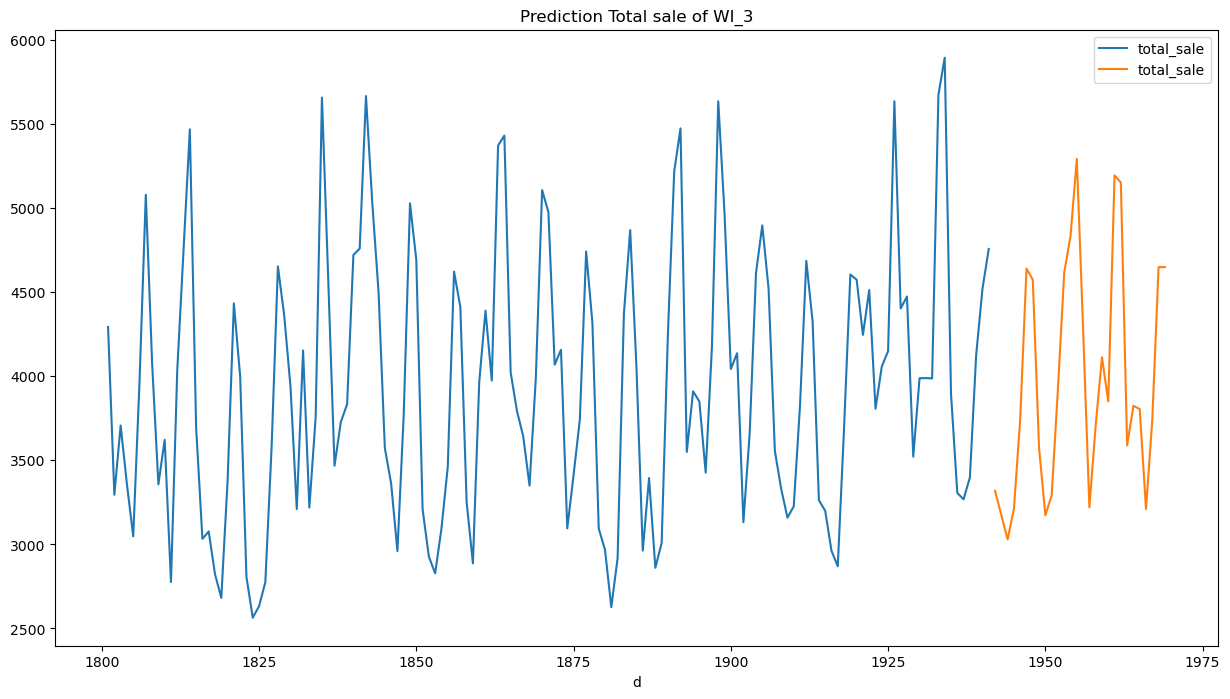

In [19]:
df[(df["d"] > 1800) & (df["d"] <= 1941)][["d", "total_sale"]].set_index("d").plot(figsize=(15,8))
df[df["d"] > 1941][["d", "total_sale"]][["d", "total_sale"]].set_index("d").plot(ax=plt.gca())
plt.title("Prediction Total sale of WI_3")
plt.show();

In [20]:
model = joblib.load("/kaggle/working/model_store_CA_1.pkl")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

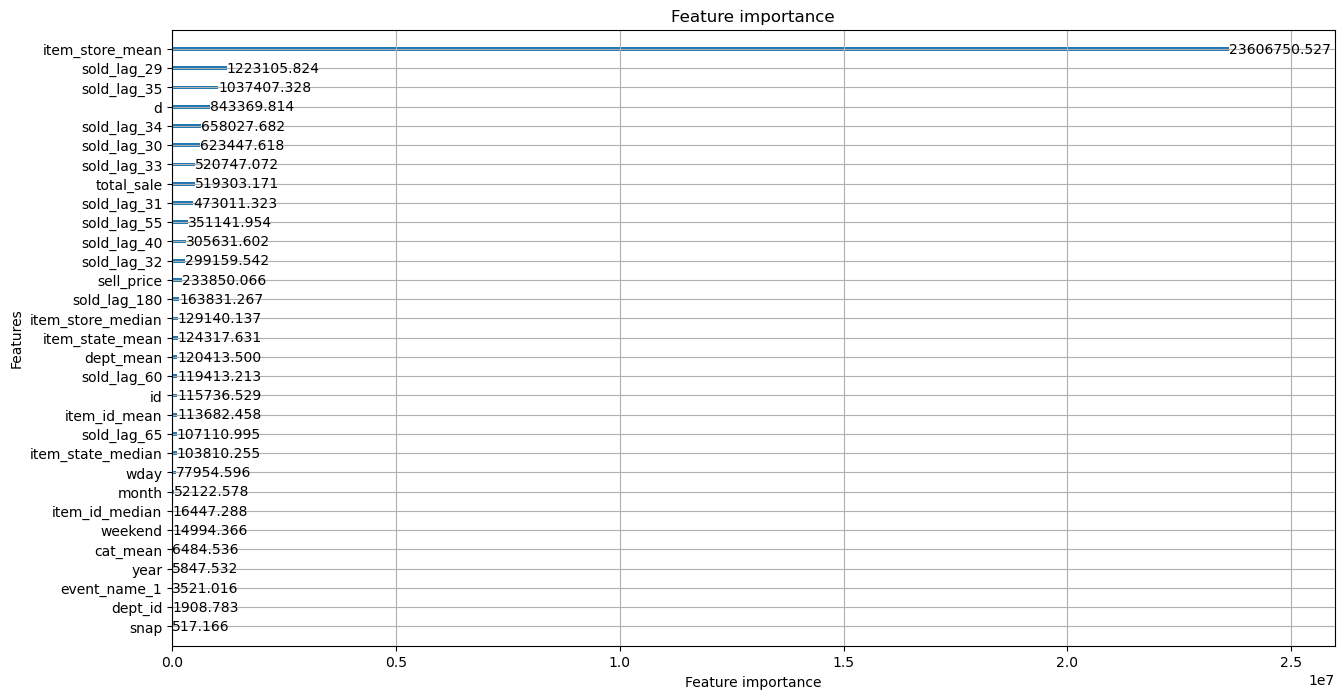

In [21]:
lgb.plot_importance(model, importance_type="gain", figsize=(15,8))

In [22]:
valid["id"] = valid["id"].map(d_id)
valid = valid.pivot(index="id", columns="d", values="sold").reset_index()
valid["id"] = valid["id"].str.replace("evaluation", "validation")

sample_sub = sample_sub[["id"]]

f_col = [f"F{i}" for i in range(1,29)]
f_col.insert(0, "id")

out_val = pd.merge(left=sample_sub[:30490], right=valid, on="id")
out_val.columns=f_col

test["id"] = test["id"].map(d_id)
test = test.pivot(index="id", columns="d", values="sold").reset_index()

out_eva = pd.merge(left=sample_sub[30490:], right=test, on="id")
out_eva.columns=f_col

submit = pd.concat([out_val,out_eva], ignore_index=True)

In [23]:
submit

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.702434,0.538821,0.656871,0.489928,0.623813,0.718605,0.695987,0.615895,0.419429,...,0.663495,0.853900,0.897191,0.593037,0.665797,0.516981,0.628622,0.785522,0.876957,0.933104
1,HOBBIES_1_002_CA_1_validation,0.416909,0.386580,0.377341,0.407904,0.423053,0.540651,0.474654,0.292528,0.276930,...,0.221337,0.302175,0.285240,0.217662,0.192198,0.232845,0.312094,0.309465,0.353009,0.362836
2,HOBBIES_1_003_CA_1_validation,0.264004,0.239294,0.261439,0.247069,0.352122,0.338877,0.245444,0.310880,0.189455,...,0.329227,0.462499,0.528532,0.444389,0.456041,0.468511,0.489823,0.500778,0.578417,0.599089
3,HOBBIES_1_004_CA_1_validation,2.057890,1.803734,1.673991,1.604271,1.579818,2.730704,2.628547,1.629329,1.600282,...,1.862992,2.333254,2.634673,1.766291,1.707348,1.906322,1.509328,1.698387,2.598170,3.355303
4,HOBBIES_1_005_CA_1_validation,1.207758,0.897546,0.773211,0.978751,1.423308,1.688924,2.179678,1.270472,1.194074,...,1.320478,1.445345,1.852488,1.138116,0.905192,0.925050,0.900469,1.070849,1.649419,1.656802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.497653,0.381194,0.376855,0.420008,0.603133,0.702044,0.682794,0.477482,0.550225,...,0.587017,0.825545,0.709582,0.689890,0.574079,0.672932,0.515538,0.622785,0.738878,0.937243
60976,FOODS_3_824_WI_3_evaluation,0.273629,0.262611,0.363955,0.446406,0.691078,0.760911,0.587550,0.546306,0.410813,...,0.283293,0.357373,0.375570,0.274445,0.325285,0.274729,0.229907,0.449685,0.428790,0.612040
60977,FOODS_3_825_WI_3_evaluation,0.644816,0.553189,0.601151,0.558294,0.820760,1.079443,1.038459,0.765788,0.841567,...,1.350886,1.268665,1.262646,0.848135,1.228479,0.946215,0.690232,0.828906,1.047548,1.245970
60978,FOODS_3_826_WI_3_evaluation,0.935055,0.927886,0.918885,1.217375,1.208725,1.417500,1.336441,0.993159,0.968593,...,1.036053,1.180982,1.044506,0.957841,1.232958,1.360145,1.117855,1.087757,1.408410,1.322824


In [24]:
submit.to_csv('submission.csv',index=False)